In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import random
import matplotlib.pylab as plt
import cv2
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import MobileNet
%matplotlib inline

Using TensorFlow backend.


In [2]:
images = glob('/Users/shubhvarma/Downloads/sample/images/*.png')
labels = pd.read_csv('/Users/shubhvarma/Downloads/sample/sample_labels.csv')

In [3]:
cv2.imread('/Users/shubhvarma/Downloads/sample/images/00000003_000.png')

In [4]:
#drop unused columns
labels = labels.drop(labels.columns.tolist()[6:], axis=1)

#create new columns for each decease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis',
                  'Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia', 
                  'No Finding']

for pathology in pathology_list :
    labels[pathology] = labels['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

#remove Y after age
labels['Age']=labels['Patient Age'].apply(lambda x: x[:-1]).astype(int)
labels = labels.drop('Patient Age', axis = 1)

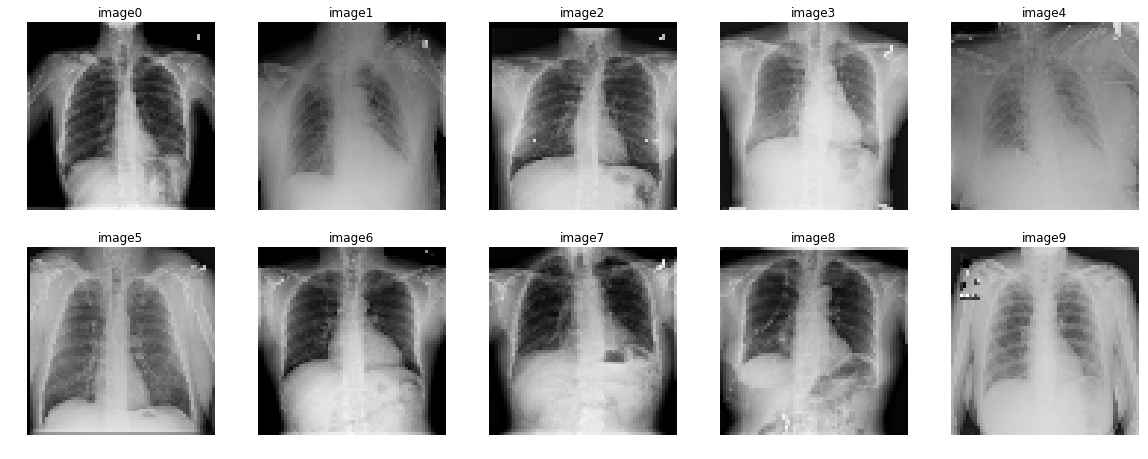

In [5]:
#multipleImages = glob('/kaggle/input/sample/sample/images/**')
index = 0
plt.rcParams['figure.figsize'] = (20, 20)
plt.subplots_adjust()
for image in images[:10]:
    im = cv2.resize(cv2.imread(image), (64, 64)) 
    plt.subplot(5, 5, index+1).set_title('image'+str(index))
    plt.imshow(im); plt.axis('off')
    index+=1

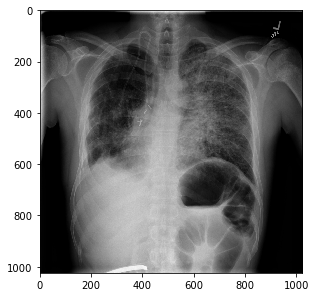

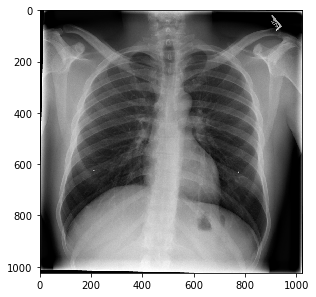

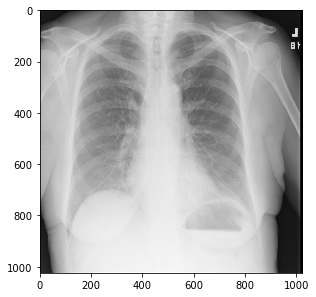

In [6]:
r = random.sample(images, 3)

for i, j in zip([0,1,2],[131,132,133]):
    plt.figure(figsize=(16,16))
    plt.subplot(j)
    plt.imshow(cv2.imread(r[i]))
    plt.show()

In [19]:
#Convert annotated .png images into labeled numpy arrays.  Discard all images with more than one pathology.
df=labels
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]

In [20]:
data=labels.groupby('Finding Labels').count().sort_values('Image Index', ascending=False)

In [11]:
%%time
image_pixel_list = []
for img in images:
    base = os.path.basename(img)
    #var1=tf.image.decode_png(img, channels=3, dtype=tf.uint8)
    #var2=tf.image.resize_images(var1,(128,128),method=tf.image.ResizeMethod.BILINEAR,align_corners=True)
    #var3=tf.reshape(var2, [1,128,128,3])
    #var4=tf.cast(var3, tf.float32)
    fullImg = cv2.resize(cv2.imread(img), (128,128), interpolation=cv2.INTER_LINEAR)
    image_pixel_list.append([fullImg, base])

image_df = pd.DataFrame(image_pixel_list, columns=['image_pixels', 'Image Index'])
df = pd.merge(labels, image_df, how='left',on='Image Index')

CPU times: user 1min 23s, sys: 10.5 s, total: 1min 34s
Wall time: 1min 47s


In [29]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [43]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
weight_path = '/Users/shubhvarma/Downloads/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
im_size = 128

def vgg16network(a,b,c,d,e,f,g):
    num_class = f
    epochs = g
    base_model = VGG16(#weights='imagenet',
        weights = weight_path, include_top=False, input_shape=(im_size, im_size, 3))
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='sigmoid')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1)
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    #confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    #plotKerasLearningCurve()
    #plt.show()
    #plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    #plt.show()
    return model
#vgg16network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,8,5)

In [45]:
def runCNNconfusion(a,b,c,d,e,f,g,h):
    # In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
    batch_size = 128
    num_classes = f
    epochs = g
    #img_rows, img_cols = X_train.shape[1],b.shape[2]
    input_shape = (128, 128, 3)
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape,strides=h))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(1024, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))
    # Define the optimizer
    optimizer = Adagrad()
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.4,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.4,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, class_weight = e,  validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0) 
    plot_learning_curve(history)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    print('\nKeras CNN #2B - accuracy:', score[1],'\n')
    Y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))
    plt.show()
#runCNNconfusion(X_train, Y_trainHot, X_test, Y_testHot,class_weight,8,6,1)

In [49]:
runCNNconfusion(X_train, Y_train, X_test, Y_test,class_weight,1,1,1)

ValueError: setting an array element with a sequence.

In [20]:
X = df["image_pixels"]
y = df['Pneumonia']

In [21]:
X[0].shape

(128, 128, 3)

In [ ]:
for i in range(len(X)):
    print(i)
    X[i] = X[i].reshape(1,128,128,3)

/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
X.shape

(5606,)

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [41]:
X_train.shape

(4484,)

In [22]:
class_weight.compute_class_weight('balanced', np.unique(y), y)

array([  0.50559163,  45.20967742])

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print("Old Class Weights: ",class_weight)

from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight)

In [36]:
Y_test.shape

(1122,)

(4484,)

In [44]:
%%time
vgg16network(X_train, Y_train, X_test, Y_test,.5,1,1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

ValueError: Error when checking input: expected input_13 to have 4 dimensions, but got array with shape (4484, 1)

In [109]:
model2 = Sequential()
model2.compile(optimizer = Adagrad() , loss = "categorical_crossentropy", metrics=["accuracy"])
model2.fit(X_train, Y_train, X_test, Y_test)

TypeError: Sequential model cannot be built: model is empty. Add some layers first.

In [110]:
var4

<tf.Tensor 'Reshape_5608:0' shape=(1, 128, 128, 3) dtype=float32>

In [122]:
sess = tf.Session()
with sess.as_default():
    nparray2 = var4.eval()
    print(nparray2)

InvalidArgumentError: Expected image (JPEG, PNG, or GIF), got unknown format starting with '/Users/shubhvarm'
	 [[Node: DecodePng_5618 = DecodePng[channels=3, dtype=DT_UINT8, _device="/job:localhost/replica:0/task:0/device:CPU:0"](DecodePng_5618/contents)]]

Caused by op 'DecodePng_5618', defined at:
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-80-a2bbcaa3cc65>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', "image_pixel_list = []\nfor img in images:\n    base = os.path.basename(img)\n    var1=tf.image.decode_png(img, channels=3, dtype=tf.uint8)\n    var2=tf.image.resize_images(var1,(128,128),method=tf.image.ResizeMethod.BILINEAR,align_corners=True)\n    var3=tf.reshape(var2, [1,128,128,3])\n    var4=tf.cast(var3, tf.float32)\n    image_pixel_list.append([var4, base])\n\nimage_df = pd.DataFrame(image_pixel_list, columns=['image_pixels', 'Image Index'])\ndf = pd.merge(labels, image_df, how='left',on=labels['Image Index'])")
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2115, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-59>", line 2, in time
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/magics/execution.py", line 1185, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 4, in <module>
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gen_image_ops.py", line 697, in decode_png
    name=name)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/shubhvarma/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Expected image (JPEG, PNG, or GIF), got unknown format starting with '/Users/shubhvarm'
	 [[Node: DecodePng_5618 = DecodePng[channels=3, dtype=DT_UINT8, _device="/job:localhost/replica:0/task:0/device:CPU:0"](DecodePng_5618/contents)]]
